# Kernel SVM - Digits (+open questions)
In the accompanying notebook the digits dataset is loaded. This dataset contains 8x8 pixel images of digits from 0-9. We train a kernel SVM in this exercise to predict the digits. 

The following code has already been provided:

In [1]:
# Standard scientific Python imports
import numpy as np
import matplotlib.pyplot as plt

#sklearn imports
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

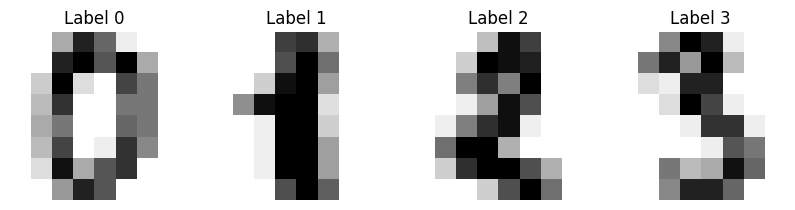

In [2]:
#Load the data
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Label %i" % label)

In [3]:
# flatten the images
n = len(digits.images)
D = digits.images.reshape((n, -1))
y = digits.target

# Split data into 70% train and 30% test subsets
D_train, D_test, y_train, y_test = train_test_split(
    D, y, test_size=0.3, shuffle=False
)

## 7a (3pts)
Train an RBF kernel SVM with parameters `gamma=0.0008`, `C=0.9`. Use the SVC SVM model from sklearn to do so. Train the model on the `D_train` dataset (70-30 split) and test the model on the `D_test` dataset.

In [4]:
from sklearn import svm

clf = svm.SVC(gamma=0.0008, C=0.9) #rbf is the default kernel
clf.fit(D_train, y_train)

SVC(C=0.9, gamma=0.0008)

What is the accuracy of the model on the test data?

In [5]:
y_pred = clf.predict(D_test)
accuracy = sum(y_pred == y_test)/len(y_test)
accuracy

0.9629629629629629

## 7b (5pts)
The multiclass SVM from sklearn uses a one-vs-one scheme: one SVM is learned for each combination of two classes. Correspondingly, we can interpret the support vectors based on our knowledge on what happens "under the hood". To that end, explain first how the prediction of a class $y\in\{−1,1\}$ is determined by the support vectors of that SVM. State the prediction formula for SVMs and explain where we find the support vectors in the formula and how the prediction works depending on the kernel, the support vectors and the learned parameters.

Intuitively the prediction for some new point $\mathbf{x}$ can be thought of as a question of whether $\mathbf{x}$ is on the positive or negative side of a barrier, whose general shape is determined by the kernel (in case of the linear kernel, this barrier would be a hyperplane) and whose exact position is determined by the support vectors, such that it is *farthest* away from them.

The exact prediction formula for a class $y \in \{-1, 1\}$ kernel SVM is the following:
$$h(\mathbf{x})=\text{sign}\left(\displaystyle\sum_i\alpha_i^*y_ik(\mathbf{x}_i,\mathbf{x})-b^*\right)$$

Here the learned parameters are $b^*$ the bias, and the $\alpha_i$-s who are the coefficients of the support vectors (the `dual_coefficient` in `sklearn.svc`is $= \alpha_iy_i$). The $\mathbf{x}_i$-s are the test data (and $y_i$-s are their labels), and those $\mathbf{x}_i$-s whose coefficient $\alpha_i$ is not $0$ are called the support vectors (in practice it is sufficient to only ever calculate with these). Finally, our kernel $k$ is a positive definite function that assigns a real number to a pair of vectors (it is the Gaussian kernel in our case as we chose rbf).

So using the kernel we obtain a number of similarity measures between our point and the support vectors (the points of the training set that were deemed to be 'on the edge'), the sign of these similarities is then provided by the training labels of the support vectors, and then we take the weighted sum of the signed similarities where the weights are the learned coefficients 'the relative importance of each support vector'. Finally, a bias (also learned) is added to the sum, and the final prediction is the sign of the result.

## 7c (4pts)
Sklearn has a peculiar way to denote the learned support vectors. To understand how this works read section 1.4.1.1 on [this website](https://scikit-learn.org/stable/modules/svm.html#svm-multi-class), including the multi-class strategies and answer the following questions for the model obtained in question part a.

The number of support vectors belonging to class `0` can be obtained as `clf.n_support_[0]`.

Furthermore the dual coefficients of these SVs are stored in the array `clf.dual_coef_`, more precisely they are the first `n=clf.n_support_[0]` elements of one of the rows, int this case row `0`.

In general to find the coefficients of the support vectors between class `a` and `b` we can refer to the table found in the link above, and for the names of the attributes we can refer to the documentation of SVC.

How many support vectors are there to distinguish between classes 0 and 1?

Note that `clf.n_support[i]` denotes the total number of supprot vecotrs belongig to class `i`. So this is the number of SVs that are used to differentiate class `i` from *any* other class.

In [6]:
clf.n_support_[0], clf.n_support_[1]

(37, 75)

- The Coefficients of the support vectors from class 0 to class 1 are the first 37 elements of the first row, thus 37 is the number of SVs belonging to class 0.
- The coefficients for the support vectors from class 1 to class 0 are the 38th to the 75+37th elements. 
- Finally we take only the nonzero cefficients as the SVs whose coefficients are 0 don't actually matter, given they are not support vectors between these two classes. 

In [7]:
# The first 37 elements of the first row, since 1 is the smallest class that is not 0, and class 0 has 37 SVs. 
supp_coef_0to1 = clf.dual_coef_[0][0:clf.n_support_[0]] 

#The first 75 elements of the first row skipping 37, since 0 is the smallest class (that is not 1), 
#and class 0 has 37 SVs that we need to skip, while class 1 has 75 that we are interested in. 
supp_coef_1to0 = clf.dual_coef_[0][clf.n_support_[0]:clf.n_support_[0]+clf.n_support_[1]] 

#we count all the nonzero coefficients, as these are the ones that are actually support vectors between classes 0 and 1
nonzero_supp = np.count_nonzero(supp_coef_0to1) + np.count_nonzero(supp_coef_1to0)
print(f"The number of support vectors to distinguish between classes 0 and 1: {nonzero_supp}")

The number of support vectors to distinguish between classes 0 and 1: 41


## 7d (12pts)
1. Explain how you extract the support vectors for the SVM classifying between 0 and 1 from the sklearn model. Include screenshots of your code to make clear how you arrive at your result for Question c.


2. Use the plotting function from the notebook to plot four of the support vectors for each class (four support vectors for class 0 and four for class 1) that are most influential for the SVM discriminating between class 0 and 1. Explain how and why you chose the plotted support vectors.


For each four we want to pick the four support vectors whose coefficients are greatest (absolute value), as this should indicate that they are the most important for making the decision. To find these we can just find the indicies of the four largest elements in the coefficient arrays we obtained for the previous exercise.

In [8]:
#get the indicies of the four most significant support vectors in each class (with respect to the other class)
significant_0to1 = np.abs(supp_coef_0to1).argsort()[-4:] #abs is not needed as all are >= 0
significant_1to0 = np.abs(supp_coef_1to0).argsort()[-4:] + clf.n_support_[0] #could be argmin as all are <= 0
significant_0to1, significant_1to0

(array([30,  6, 31, 19], dtype=int64),
 array([110,  87,  45, 111], dtype=int64))

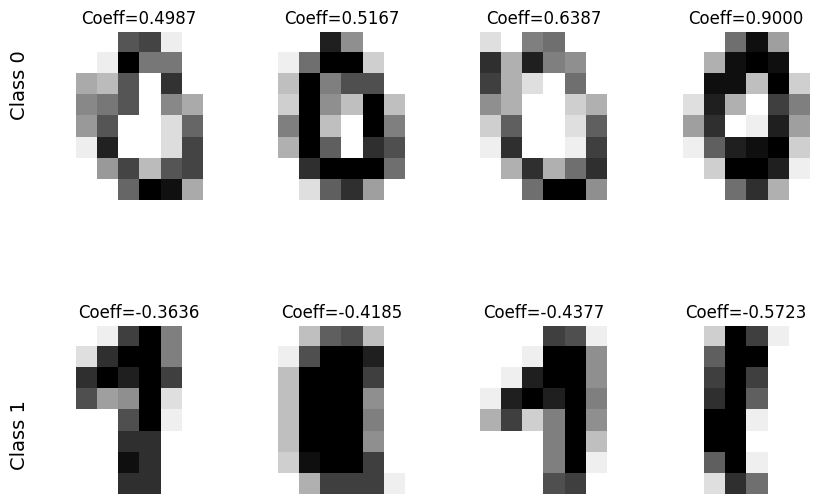

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 7)) # get the plot

fig.text(0.08, 0.75, "Class 0", fontsize=14, rotation=90, va='center')
fig.text(0.08, 0.25, "Class 1", fontsize=14, rotation=90, va='center')

#plot of the SVs of class 0
for ax, image, label in zip(axes[0, :], clf.support_vectors_[significant_0to1], supp_coef_0to1[significant_0to1]):
    ax.set_axis_off()
    ax.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Coeff=%.4f" % label)
#plot of the SVs of class 1    
for ax, image, label in zip(axes[1, :], clf.support_vectors_[significant_1to0], supp_coef_1to0[(significant_1to0 - clf.n_support_[0])]):
    ax.set_axis_off()
    ax.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Coeff=%.4f" % label)

3. Based on the role that the support vectors have in the prediction, what would you expect what the plotted support vectors look like, or what characteristic they would have? Do you see these characteristics in the plotted support vectors or are you surprised by the result?

Our general expectation is that the most significant support vectors will be the images that are most easily confusable for the other class.
So based on this we can say that `coeff=0.90` and `coeff=-0.41` are both images that matched this expectation, as we can clearly see a resemblence to the other digit in them. However the importance of some of the others is somewhat less evident, thus we can say that the overall results are somewhat surprising.

## 7e (6pts)
Use the sklearn function `GridSearchCV` to determine the best combination for the parameters `gamma` and `C` according to a 5-fold cross validation of the SVC SVM with RBG kernel. Train the model on the whole dataset `D`, not just `D_train`. Use as the scoring method the accuracy and set as the candidate parameters $gamma \in \{0.0001,0.0006,0.001,0.006\}$ and $C \in \{0.6,0.8,1,2,3,4,6\}$.

In [14]:
import sklearn.model_selection


gammas = [0.0001, 0.0006, 0.001, 0.006]
Cs = [0.6, 0.8, 1, 2, 3, 4, 6]

# while the exercise asks for RBG kernel which doesn't exist, it is reasonable to assume the it meant to say RBF.
grid_svc = svm.SVC(kernel='rbf') 
grid_clf = sklearn.model_selection.GridSearchCV(grid_svc, {"gamma":gammas, "C":Cs}, scoring='accuracy', cv=5)
grid_clf.fit(D, y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.6, 0.8, 1, 2, 3, 4, 6],
                         'gamma': [0.0001, 0.0006, 0.001, 0.006]},
             scoring='accuracy')

In [15]:
import pandas as pd
pd.DataFrame(grid_clf.cv_results_).sort_values(['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.100408,0.008937,0.058927,0.002516,6,0.0006,"{'C': 6, 'gamma': 0.0006}",0.983333,0.955556,0.983287,0.991643,0.958217,0.974407,0.014650,1
17,0.074973,0.004217,0.049982,0.004510,3,0.0006,"{'C': 3, 'gamma': 0.0006}",0.983333,0.950000,0.983287,0.994429,0.958217,0.973853,0.016827,2
21,0.093431,0.008595,0.062509,0.004999,4,0.0006,"{'C': 4, 'gamma': 0.0006}",0.983333,0.950000,0.983287,0.991643,0.958217,0.973296,0.016170,3
14,0.122485,0.004570,0.072909,0.010594,2,0.001,"{'C': 2, 'gamma': 0.001}",0.977778,0.950000,0.983287,0.988858,0.963788,0.972742,0.014097,4
13,0.093530,0.012587,0.056376,0.001352,2,0.0006,"{'C': 2, 'gamma': 0.0006}",0.983333,0.947222,0.983287,0.991643,0.958217,0.972741,0.016987,5


What are the parameters resulting in the highest cross-validated scores?

It is assumed taht the exercise is asking for the 'highest mean test score' when it said 'highest cross-validated scores', but there is no universal winner.

In [18]:
print(f"Resulting highes cross-validated scores: {grid_clf.best_params_}")

Resulting highes cross-validated scores: {'C': 6, 'gamma': 0.0006}


What is the mean cross-validates accuracy of these parameters?

'mean cross-validates accuracy of these parameters' = mean cross-validate**d** score of **the estimator with** these parameters

In [19]:
print(f"Accuracy: {grid_clf.best_score_}")

Accuracy: 0.9744073042401734
